In [1]:
import numpy as np
import gymnasium as gym
import pygame
from algorithms.rl import RL
from algorithms.planner import Planner
from examples.test_env import TestEnv
from examples.plots import Plots
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import pandas as pd
import warnings

import math
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time


import seaborn as sns
sns.set_theme()



In [2]:
#black jack unique imports
from blackjack import Blackjack
from __future__ import annotations
from collections import defaultdict
from matplotlib.patches import Patch
from tqdm import tqdm
import pickle

## define new functions---------------------

In [3]:
def grid_values_heat_map_new(data, label):
        if not math.modf(math.sqrt(len(data)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            size = int(math.sqrt(len(np.array(data))))
            data = np.around(np.array(data).reshape((size, size)), 2)
            df = pd.DataFrame(data=data)
            sns.heatmap(df, annot=True, annot_kws={"size": 8}).set_title(label)
            plt.show()

In [4]:
def addlabels (x,y):
    for i in range (len(x)):
        if round(y[i],4) < 0:
            plt.text (-0.1*i+1, round(y[i],4) - 0.005, round (y[i],2), ha = 'center')
        else:
            plt.text (-0.1*i+1, round(y[i],4), round (y[i],2), ha = 'center')

In [5]:
#define agent for Q leanrning
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [6]:
def create_grids_3d(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots_3d(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"Value")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


In [7]:
def create_grids_2d(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value_grid = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    #value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots_2d(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    #player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1)
    value_grid = np.around(value_grid,2)
    #ax1 = sns.heatmap(value_grid, linewidth=0, annot=True, cmap="viridis", cbar=False, annot_kws={"size": 8})
    ax1 = sns.heatmap(value_grid, linewidth=0, annot=True, annot_kws={"size": 8})
   

    ax1.set_title("Reward")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.set_xticklabels(range(12, 22))
    ax1.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
    
   

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title("Policy")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig



## set env-----------------------

In [8]:
'''
black jack
'''

#set black jack env (21)
black_jack_small = gym.make("Blackjack-v1", sab=True)


#set black jack env (large)


In [9]:
print ('small problem action space is: ', black_jack_small.action_space, '\nsmall state space is: ', black_jack_small.observation_space)
print('total state space size: ', 32*11*2)


small problem action space is:  Discrete(2) 
small state space is:  Tuple(Discrete(32), Discrete(11), Discrete(2))
total state space size:  704


In [10]:
# reset the environment to get the first observation
done = False
observation, info = black_jack_small.reset()
observation

(20, 8, 1)

# Q LEARNING------------------

In [11]:
# Q learner for small set
learning_rate = 0.01
n_episodes = 500000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

q_agent_small = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

## Q learning training process
env = gym.wrappers.RecordEpisodeStatistics(black_jack_small, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = q_agent_small.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        q_agent_small.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    q_agent_small.decay_epsilon()

100%|██████████| 500000/500000 [01:19<00:00, 6271.87it/s]


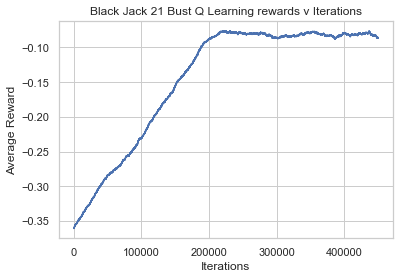

In [12]:
#reward vs iteration plot
rolling_length = 50000
sns.set_theme(style="whitegrid")

plt.title("Black Jack 21 Bust Q Learning rewards v Iterations")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
plt.plot(range(len(reward_moving_average)), reward_moving_average)
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.show()

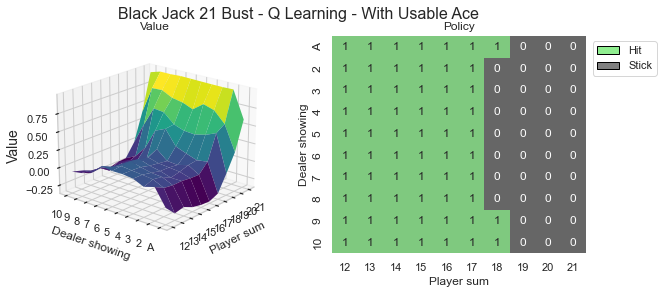

In [13]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(q_agent_small, usable_ace=True)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - Q Learning - With Usable Ace")
plt.show()

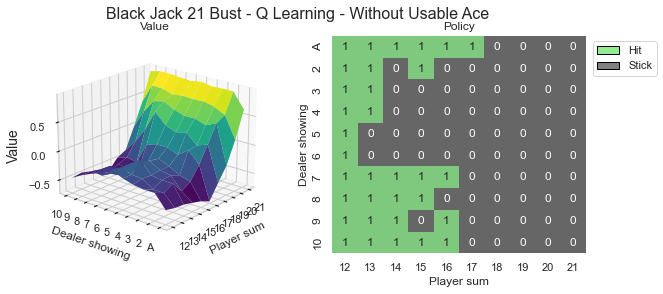

In [14]:
# state values & policy with not usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(q_agent_small, usable_ace=False)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - Q Learning - Without Usable Ace")
plt.show()

# VI ------------------

In [15]:
# VI for small set
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

vi_agent_small = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

## vi training process
env = gym.wrappers.RecordEpisodeStatistics(black_jack_small, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = vi_agent_small.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        vi_agent_small.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    vi_agent_small.decay_epsilon()

100%|██████████| 1000000/1000000 [02:35<00:00, 6425.36it/s]


In [16]:
#create black jack env for vipi
black_jack_vipi_small = Blackjack()

In [17]:
#vi_small
V, V_track, pi = Planner(black_jack_vipi_small.P).value_iteration(gamma=0.9, n_iters=1000)

runtime = 0.02 seconds


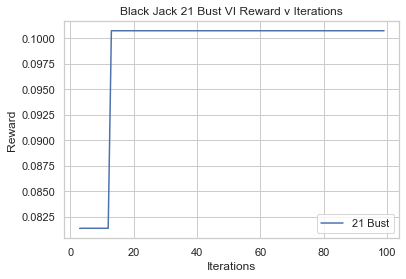

In [18]:
#plot reward v iterations for both small

max_reward_per_iter_small = np.mean(V_track, axis=1)
max_reward_per_iter_small[max_reward_per_iter_small==0.0] = np.max(np.mean(V_track, axis=1))
#max_reward_per_iter_large = np.amax(V_track, axis=1)


df = pd.DataFrame(data=max_reward_per_iter_small)
#df_2 = pd.DataFrame(data=max_reward_per_iter_large)
label = "Black Jack 21 Bust VI Reward"
df.columns = [label]
#df_2.columns = [label]
sns.set_theme(style="whitegrid")
plt.title('Black Jack 21 Bust VI Reward v Iterations')
plt.plot(df.index[3:100], df['Black Jack 21 Bust VI Reward'][3:100])
#plt.plot(df_2.index[:200], df_2['Frozen Lake PI Reward'][:200])
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend(['21 Bust','15X15 Size'], loc = 'lower right')
plt.show()

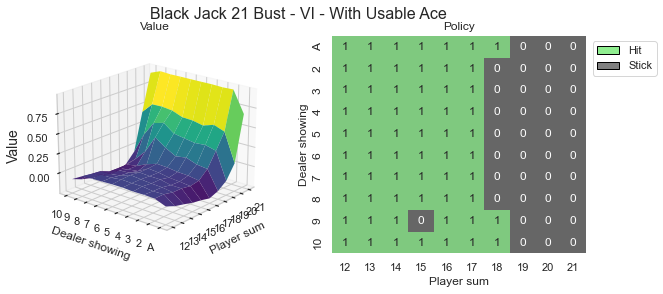

In [31]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(vi_agent_small, usable_ace=True)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - VI - With Usable Ace")
plt.show()

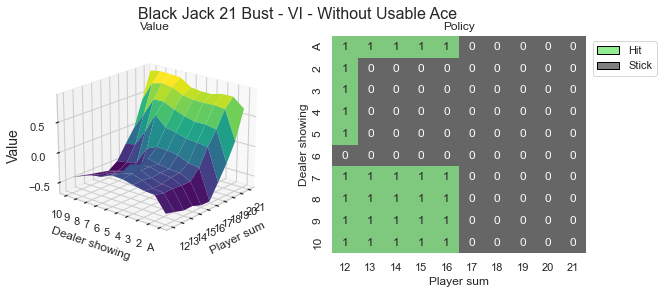

In [32]:
# state values & policy with not usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(vi_agent_small, usable_ace=False)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - VI - Without Usable Ace")
plt.show()

# PI ------------------

In [21]:
#Pi_small
V, V_track, pi = Planner(black_jack_vipi_small.P).policy_iteration(gamma=0.9, n_iters=1000)

runtime = 0.33 seconds


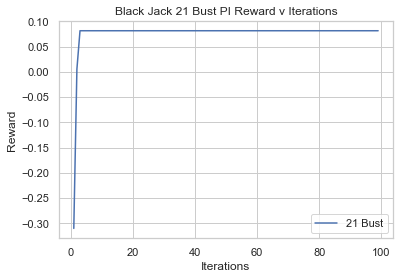

In [22]:
#plot reward v iterations for both small

max_reward_per_iter_small = np.mean(V_track, axis=1)
max_reward_per_iter_small[max_reward_per_iter_small==0.0] = np.max(np.mean(V_track, axis=1))
#max_reward_per_iter_small = np.amax(V_track, axis=1)


df = pd.DataFrame(data=max_reward_per_iter_small)
#df_2 = pd.DataFrame(data=max_reward_per_iter_large)
label = "Black Jack 21 Bust PI Reward"
df.columns = [label]
#df_2.columns = [label]
sns.set_theme(style="whitegrid")
plt.title('Black Jack 21 Bust PI Reward v Iterations')
plt.plot(df.index[1:100], df['Black Jack 21 Bust PI Reward'][1:100])
#plt.plot(df_2.index[:200], df_2['Frozen Lake PI Reward'][:200])
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend(['21 Bust','15X15 Size'], loc = 'lower right')
plt.show()

In [23]:
# PI for small set
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 0.99
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

pi_agent_small = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

## pi training process
env = gym.wrappers.RecordEpisodeStatistics(black_jack_small, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = pi_agent_small.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        pi_agent_small.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    pi_agent_small.decay_epsilon()

100%|██████████| 1000000/1000000 [02:35<00:00, 6439.66it/s]


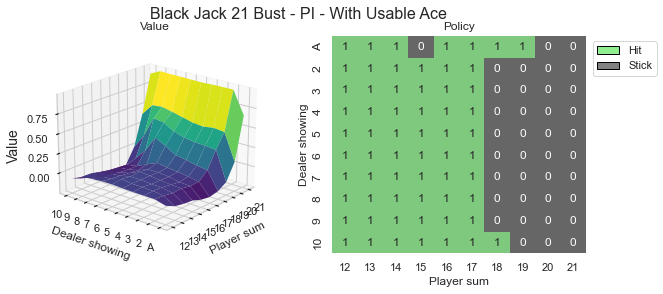

In [33]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(pi_agent_small, usable_ace=True)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - PI - With Usable Ace")
plt.show()

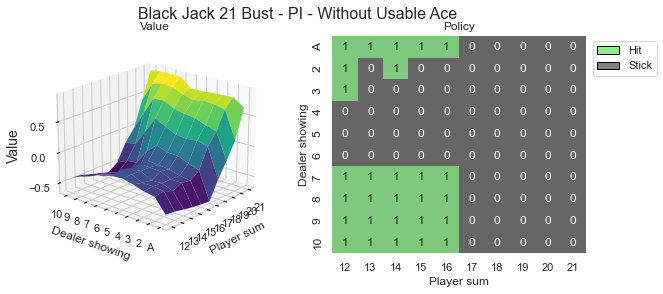

In [34]:
# state values & policy with not usable ace (ace counts as 11)
value_grid, policy_grid = create_grids_3d(pi_agent_small, usable_ace=False)
fig1 = create_plots_3d(value_grid, policy_grid, title="Black Jack 21 Bust - PI - Without Usable Ace")
plt.show()

# TEST Q LEARNING EXPORATION * EXPLOITATION -------------------

In [26]:
#try different episilon with same decay ratio
epsilon_lst = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
Q_lst=[]
V_lst=[]
pi_lst=[]
Q_track_lst=[]
pi_track_lst=[]
wall_clock_lst = []
for e in epsilon_lst:
    # Q learner for small set
    learning_rate = 0.01
    n_episodes = 100000
    start_epsilon = e
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.1

    q_agent_small = BlackjackAgent(
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
    )

    ## Q learning training process
    env = gym.wrappers.RecordEpisodeStatistics(black_jack_small, deque_size=n_episodes)
    start = time.time()
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = q_agent_small.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent
            q_agent_small.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        q_agent_small.decay_epsilon()
    end = time.time()

    #record plot data and other data
    wall_clock_lst.append(end-start)

######PLOT RECORD######---------------
    #reward vs iteration plot
    rolling_length = 50000
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    
    Q_track_lst.append([range(len(reward_moving_average)), reward_moving_average])

100%|██████████| 100000/100000 [00:15<00:00, 6454.66it/s]


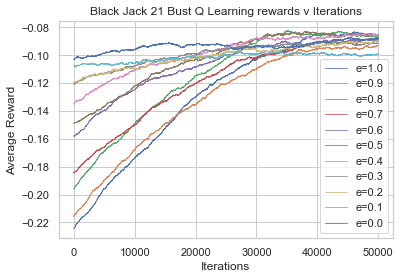

In [27]:
sns.set_theme(style="whitegrid")
plt.title("Black Jack 21 Bust Q Learning rewards v Iterations")
for q_track in Q_track_lst:
    plt.plot(q_track[0], q_track[1], linewidth = 0.8)

plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.legend(['e=1.0','e=0.9', 'e=0.8', 'e=0.7', 'e=0.6','e=0.5','e=0.4','e=0.3','e=0.2','e=0.1','e=0.0',], loc = 'lower right')
plt.show()

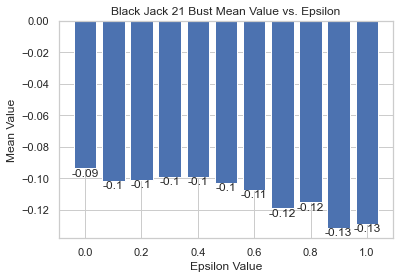

In [28]:
#mean value vs epsilon
plt.title('Black Jack 21 Bust Mean Value vs. Epsilon')
plt.bar(epsilon_lst, 
        [np.mean(Q_track_lst[i][1]) for i in range(11)],width=0.08)
addlabels(epsilon_lst,[np.mean(Q_track_lst[i][1]) for i in range(11)] )
plt.xlabel("Epsilon Value")
plt.ylabel("Mean Value")
plt.show()

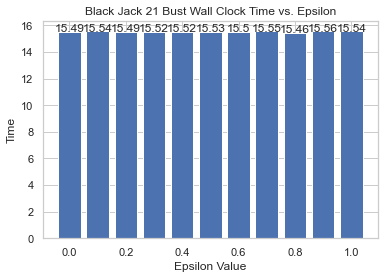

In [29]:
#wall clock time vs epsilon
plt.title('Black Jack 21 Bust Wall Clock Time vs. Epsilon')
plt.bar(epsilon_lst, wall_clock_lst,width=0.08)
addlabels(epsilon_lst,wall_clock_lst )
plt.xlabel("Epsilon Value")
plt.ylabel("Time")
plt.show()